In [1]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def nan_df(dados):
    """Cria um DataFrame com percentuais de valores NaN em cada coluna do dataframe dados
    
    Args
        dados (DataFrame): dataframe com as colunas a serem analisadas
        
    Returns:
        nan_df (DataFrame): dataframe com os percentuais
    """
    nan_count = dados.isna().sum()
    nan_df = pd.DataFrame(
        round(nan_count[nan_count!= 0]*100/dados.shape[0], 2).astype('str') + ' %', 
        columns=['NaN_perc']
    )
    return nan_df


def calculate_metrics(cluster_num, dados):
    """Calcula o valor das 3 métricas usadas aqui para clusterização: silhueta, db e ch
    
    Args:
        cluster_num (int): número de clusters
        dados (DataFrame): dataset para o agrupamento
    
    Returns:
        coef_silhueta, dbs, ch (float): valores das 3 métricas
    """
    labels = KMeans(n_clusters=cluster_num, n_init=10, max_iter=300).fit_predict(dados)
    
    coef_silhueta = silhouette_score(dados, labels, metric='euclidean')
    db = davies_bouldin_score(dados, labels)
    ch = calinski_harabasz_score(dados, labels)
    
    return coef_silhueta, db, ch


def tsne_viz(dados, agrupador, padronizador=Normalizer()):
    """Faz uma visualização do agrupador em duas dimensões, por meio da redução do algoritmo TSNE
    
    Args:
        dados (DataFrame): dataset de entrada
        agrupador (scikit cluster): agrupador (clusterizador) a usar
        padronizador (scikit scaler): padronizador para os dados de input
    """
    # Usando o padronizador Standard Scaler
    padronizador.fit(dados)
    
    # Transformando os dados iniciais e retornando a um DataFrame do pandas
    dados_tsne_np = padronizador.transform(dados)
    dados_tsne_pd = pd.DataFrame(dados_tsne_np, columns=dados.columns)
    
    # Instanciando o TSNE para duas dimensões
    tsne = TSNE(n_components=2)
    tsne_np = tsne.fit_transform(dados_tsne_pd)
    
    # Ajustando o agrupador
    agrupador.fit(dados_tsne_pd)
    
    # Label referente a cada entrada do dataset (cluster ao qual o vinho pertence)
    labels = agrupador.labels_
    
    # Visualização:
    plt.figure(figsize=(14, 8))
    scatter_plot = plt.scatter(tsne_np[:,0], tsne_np[:,1], c=labels, s=6, cmap='rainbow')
    plt.xlabel('Dimensão 1')
    plt.ylabel('Dimensão 2')
    plt.legend(handles=scatter_plot.legend_elements()[0], labels=list(np.unique(labels).astype('str')))
    plt.show()
    
    pass

In [3]:
sns.set_theme()

# 02. Obtendo os clusters

In [4]:
URI = 'https://raw.githubusercontent.com/alura-cursos/alura-clustering-validation/base-de-dados/CC%20GENERAL.csv'
dados = pd.read_csv(URI)
dados.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
# Removendo colunas que não contribuirão para o agrupamento
dados = dados.drop(columns=['CUST_ID', 'TENURE'])
# Passando nome das colunas para minúscula, por conveniência
dados.columns = dados.columns.str.lower()

In [6]:
# Procurando por valores nan/missing e exibindo como percentual do número de linhas do dataset:
nan_percs = nan_df(dados)
display(nan_percs)

,NaN_perc
credit_limit,0.01 %
minimum_payments,3.5 %


In [7]:
# Já que os percentuais de NaN são relativamente baixos, os valores de NaN serão trocados pelas
# medianas de cada coluna
for column_name in list(nan_percs.index):
    dados[column_name] = dados[column_name].fillna(dados[column_name].median())

nan_percs_fixed = nan_df(dados)
display(nan_percs_fixed)

,NaN_perc


In [8]:
# Agora, partindo para o clustering, usa-se antes um normalizador para o dataset
dados_norm = Normalizer().fit_transform(dados)

# E clusterizando com o KMeans:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300)
labels = kmeans.fit_predict(dados_norm)

### 03. Entendendo os critérios e métricas de validação

In [9]:
# Verificando a validade da clusterização por coeficiente de silhueta:
coef_silhueta = silhouette_score(dados_norm, labels, metric='euclidean')
print(f'Coeficiente de silhueta: {round(coef_silhueta, 4)}.')

Coeficiente de silhueta: 0.3645.


### 04. Entendendo e calculando o índice Davies-Bouldin

In [10]:
# Índice Davies-Bouldin, por meio do scikit:
db_score = davies_bouldin_score(dados_norm, labels)
print(f'Índice Davies-Bouldin: {round(db_score, 4)}.')

Índice Davies-Bouldin: 1.076.


### 05. Entendendo e calculando o índice Calinski Harabasz

In [11]:
# Índice Calinski-Harabasz, por meio do scikit:
ch_score = calinski_harabasz_score(dados_norm, labels)
print(f'Índice Calinski Harabasz: {round(ch_score, 2)}.')

Índice Calinski Harabasz: 3431.79.


# 06. Validando os clusters

In [12]:
cluster_num = list(range(2, 50))
resultados = []

for K in cluster_num:
    cs, db, ch = calculate_metrics(K, dados_norm)
    resultados.append([cs, db, ch])

In [13]:
# Agrupando os resultados em um dataframe e normalizando cada método pelo seu valor máximo:
resultados_df = pd.DataFrame(resultados, columns=['cs', 'db', 'ch'])
for column in list(resultados_df.columns):
    resultados_df[column] = resultados_df[column]/resultados_df[column].max()
    
resultados_df.head(5)

,cs,db,ch
0,0.819885,1.000000,0.941375
1,0.896926,0.861802,0.999356
2,0.954511,0.804492,1.000000
3,0.998929,0.708695,0.972533
4,1.000000,0.688594,0.998526


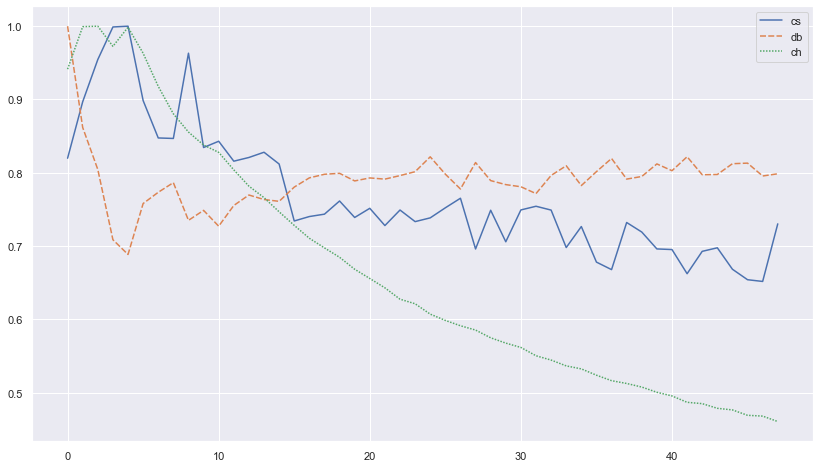

In [14]:
# Visualizando os resultados
plt.figure(figsize=(14, 8))
sns.lineplot(data=resultados_df)
plt.show()

Lembrando que, quanto maior o valor para as métricas CS e CH, melhor; ao contrário, quanto menor o DB, melhor. Da figura, o ponto mínimo para o DB corresponde a 4 clusters, para o CS e CH o ponto máximo ocorre a 5 clusters (no CS, 4 equivale a 5). 

In [15]:
# Comparando os clusters com dados aleatórios
random_data = np.random.rand(dados.shape[0], dados.shape[1])
cs, db, ch = calculate_metrics(5, random_data)
print(f'''Coeficiente de silhueta: {round(cs, 4)};
Davies-Bouldin: {round(db, 4)};
Calinski-Harabasz: {round(ch, 4)}.''')

Coeficiente de silhueta: 0.0395;
Davies-Bouldin: 3.5089;
Calinski-Harabasz: 302.3174.


Vê-se valores bem mais ajustados no dataset analisado. Um bom indicativo de que a clusterização é válida.

In [16]:
# Clusterização por partes:
set1, set2, set3 = np.array_split(dados_norm, 3)
r1 = calculate_metrics(5, set1)
r2 = calculate_metrics(5, set2)
r3 = calculate_metrics(5, set3)
split_df = pd.DataFrame([r1, r2, r3], columns=['cs', 'db', 'ch'], index=['set_1', 'set_2', 'set_3'])
display(split_df)
split_df.std()  # Desvio padrão

,cs,db,ch
set_1,0.368928,1.055833,1204.100909
set_2,0.353804,1.139494,1194.948635
set_3,0.367125,1.098878,1167.533663


cs     0.008261
db     0.041836
ch    19.028524
dtype: float64

Também contribuindo para a validação, dividir o dataset continuou apresentando resultados consistentes dentro das 3 métricas, vide o desvio padrão baixo.

# 07. Visualizando os clusters

Nessa divisão do curso, só foi abordado sobre como as visualizações dos clusters na integridade não são convenientes (muitas dimensões e muitas divisões). Sendo assim, eu só deixo uma figura com redução de dimensionalidade pra efeito visual dos clusters mesmo.

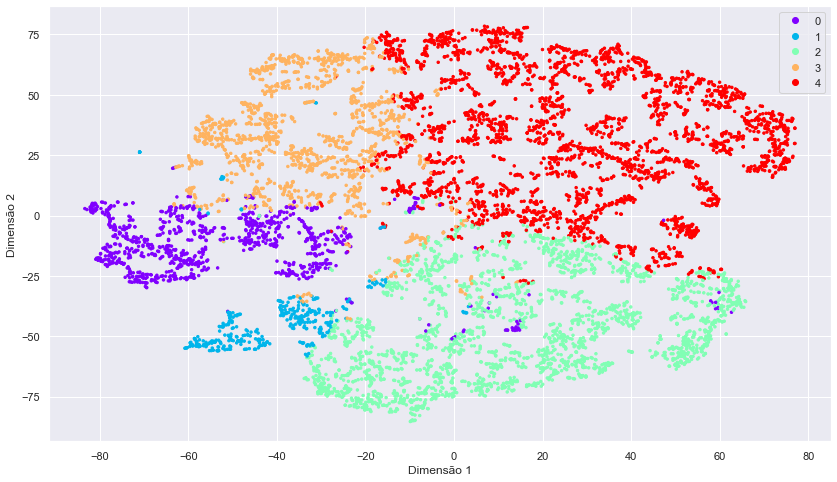

In [17]:
tsne_viz(dados, KMeans(n_clusters=5))

# 08. Entendendo os valores dos atributos no cluster

A ideia apresentada é: capturar os centroides para cada cluster (dados.shape[1] coordenadas/features); calcular a variância de cada feature; selecionar aquelas com maior variância, uma vez que essas tendem a possuir maior influência no comportamento do clustering.

In [18]:
# Resgatar os centroides do kmeans ajustado
centroides = kmeans.cluster_centers_
centroides_df = pd.DataFrame(centroides, columns=list(dados.columns))

In [19]:
# Calcualar a variância e selecionar as maiores, usando um DataFrame intermediário
centroides_var = pd.DataFrame(centroides_df.var(), columns=['var']).sort_values(by='var',ascending=False)
features = centroides_var.head().index.to_list()

display(centroides_var.head(5))
print(features)

,var
minimum_payments,0.067566
credit_limit,0.044948
payments,0.034952
cash_advance,0.028184
balance,0.027991


['minimum_payments', 'credit_limit', 'payments', 'cash_advance', 'balance']


In [20]:
# Agrupar o dataset inicial por clusters, filtrar as features e os dados
dados['cluster'] = labels
medias = dados.groupby(by='cluster')[features].mean()
medias['n_clients'] = dados.groupby('cluster').size()
display(medias)

,minimum_payments,credit_limit,payments,cash_advance,balance,n_clients
cluster,,,,,,
0,228.567586,5130.892579,814.340168,140.652097,443.776995,3279
1,1021.783892,4495.584906,968.775192,1637.380994,3036.946177,2650
2,541.422553,4098.802182,3037.137165,183.496011,1141.865757,1536
3,734.167995,3982.452201,4713.384730,3267.199032,1795.328292,1073
4,6032.349113,2226.699029,1338.974045,420.107194,1987.146873,412


# 09. Interpretando os clusters

Dos dataframes acima e abaixo, pode-se dizer:
Cluster 0: Clientes que gastam pouco; maior limite; bons pagadores; maior quantidade.
Cluster 1: Clientes que mais gastam; concentrados no saque; maus pagadores.
Cluster 2: Clientes que gastam muito com compras; melhores pagadores.
Cluster 3: Clientes que gastam muito com saques; piores pagadores.
Cluster 4: Clientes com o menor limite; não são bons pagadores; menor quantidade.

Chama a atenção o fato de que o cluster 1 possui clientes maus pagadores (praticamente tão ruins quanto os do cluster 3) e, ainda assim, possui o segundo maior limite; nos resultados observados na aula, também possuía o segundo maior número de clientes. De qualquer forma, tendo uma alta quantidade de inadimplentes de limite alto pode ser indicado revisar o formato de concessão.

In [21]:
dados.groupby('cluster')['prc_full_payment'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,3279.0,0.246881,0.346775,0.0,0.0,0.000000,0.444444,1.0
1,2650.0,0.001798,0.023256,0.0,0.0,0.000000,0.000000,0.6
2,1536.0,0.278331,0.367137,0.0,0.0,0.083333,0.545455,1.0
3,1073.0,0.117430,0.186772,0.0,0.0,0.083333,0.142857,1.0
4,412.0,0.019271,0.090795,0.0,0.0,0.000000,0.000000,1.0
